# Compare

Compare WSRA, SWIFT, and Wave Glider wave measurements during ATOMIC.

In [73]:
import glob
import re
from datetime import datetime

import cartopy
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywsra
import scipy
import xarray as xr
from IPython import get_ipython
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sharedfunctions import configure_figures, read_stored_variable

## Setup

Read stored variables from `io.pynb` and `calculate.ipnyb`.  Configure matplotlib figures using shared parameters.

Stored 'atomic_wsra' (Dataset)
Stored 'atomic_swifts' (dict)
Stored 'atomic_wave_gliders' (dict)
Stored 'atomic_ship' (Dataset)


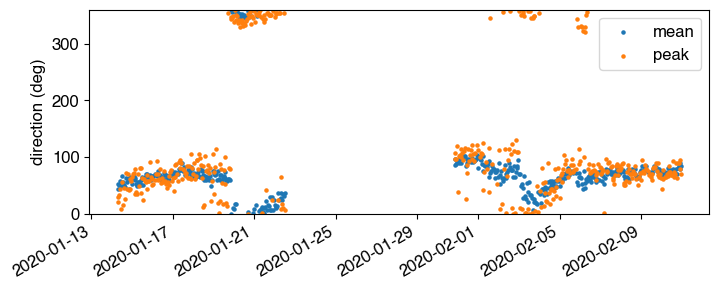

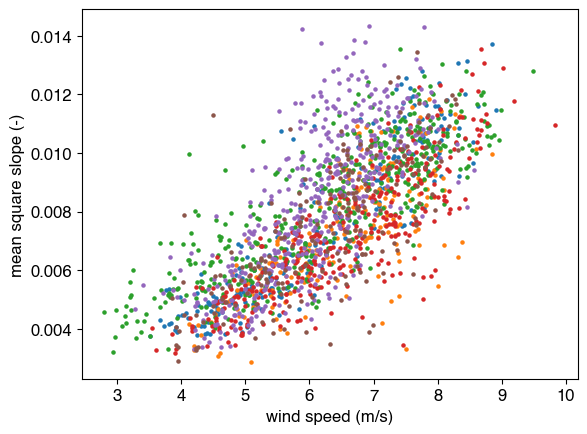

/opt/homebrew/Caskroom/miniconda/base/envs/PyWSRA/lib/python3.10/site-packages/xarray/core/accessor_dt.py:132: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [74]:
%run 'calculate.ipynb'
%run -i sharedfunctions.py
atomic_wsra = read_stored_variable('atomic_wsra')
atomic_swifts = read_stored_variable('atomic_swifts')
atomic_wave_gliders = read_stored_variable('atomic_wave_gliders')
matches_df = read_stored_variable('matches_df')

configure_figures()

## Overview

### WSRA flight path

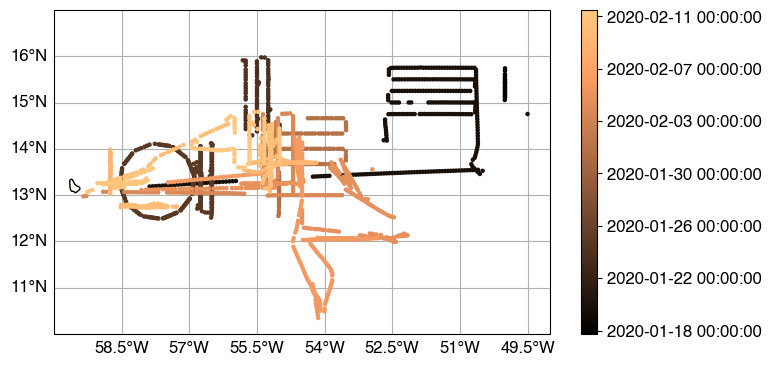

In [75]:
PROJECTION = cartopy.crs.PlateCarree()
IMAGE_RESOLUTION = 400

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=PROJECTION)

atomic_wsra.wsra.chart.ocean_color = 'white'
atomic_wsra.wsra.chart.land_color = 'floralwhite'

ax = atomic_wsra.wsra.plot(
    ax=ax,
    extent=(-60, -49, 10, 17),
    plot_best_track=False,
    column='timestamp',
    cmap='copper',
    label='WSRA',
    legend=True,
    legend_kwds={
     'shrink': 0.7,
    }
)
cax = ax.get_figure().axes[-1]
date_ticks = pd.date_range(start=atomic_wsra['time'][0].dt.ceil('D').values,
                           end=atomic_wsra['time'][-1].dt.floor('D').values,
                           freq='4D')
_ = cax.set_yticks(pd.to_numeric(date_ticks), labels=date_ticks)

# plt.savefig('wsra_hurricane_earl_time_tracks.png', dpi=IMAGE_RESOLUTION)

### WSRA flight metadata

Plot the WSRA flight metadata (altitude, roll, and ground speed).

<GeoAxes: >

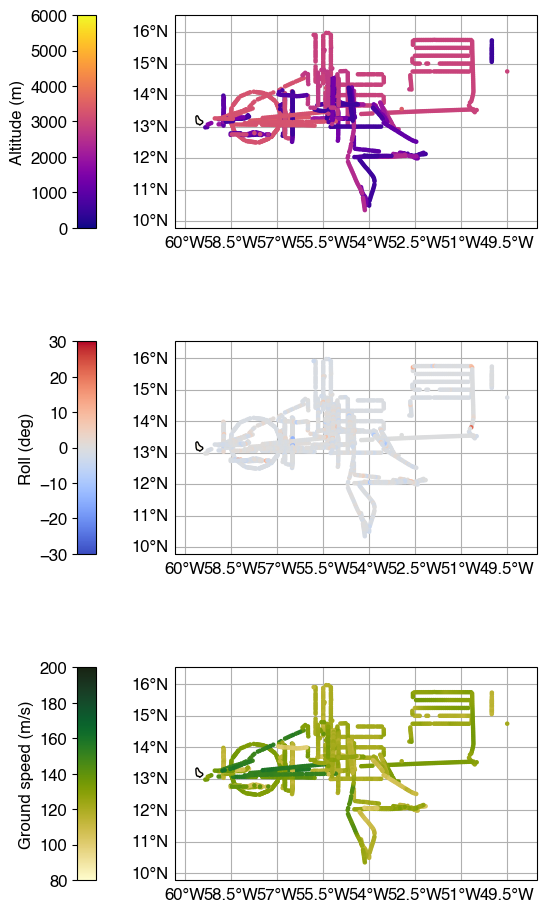

In [76]:
PROJECTION = cartopy.crs.PlateCarree()
IMAGE_RESOLUTION = 400

fig = plt.figure(figsize=(6, 12))

# Plot altitude
ax = fig.add_subplot(3, 1, 1, projection=PROJECTION)
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", axes_class=mpl.axes.Axes)
cmap = mpl.cm.plasma  # cmocean.cm.deep_r
norm = mpl.colors.Normalize(vmin=0, vmax=6000)
atomic_wsra.wsra.plot(
    column='platform_radar_altitude',  # 'ymd'
    plot_best_track=False,
    legend=True,
    cmap=cmap,
    norm=norm,
    ax=ax,
    cax=cax,
    legend_kwds={
        "label": "Altitude (m)",
        "orientation": "vertical",
        "location": "left",
    }
)

# Plot roll
ax = fig.add_subplot(3, 1, 2, projection=PROJECTION)
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", axes_class=mpl.axes.Axes)
cmap = mpl.cm.coolwarm
norm = mpl.colors.CenteredNorm(halfrange=30)
atomic_wsra.wsra.plot(
    column='wsra_computed_roll',  # 'ymd'
    plot_best_track=False,
    legend=True,
    cmap=cmap,
    norm=norm,
    ax=ax,
    cax=cax,
    legend_kwds={
        "label": "Roll (deg)",
        "orientation": "vertical",
        "location": "left",
    }
)

# Plot ground speed
ax = fig.add_subplot(3, 1, 3, projection=PROJECTION)
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", axes_class=mpl.axes.Axes)
cmap = cmocean.cm.speed
norm = mpl.colors.Normalize(vmin=80, vmax=200)
atomic_wsra.wsra.plot(
    column='platform_speed_wrt_ground',  # 'ymd'
    plot_best_track=False,
    legend=True,
    cmap=cmap,
    norm=norm,
    ax=ax,
    cax=cax,
    legend_kwds={
        "label": "Ground speed (m/s)",
        "orientation": "vertical",
        "location": "left",
    }
)

# fig.savefig(f'WSRA_flight_parameters.{IMAGE_FILE_TYPE}',
#             format=IMAGE_FILE_TYPE,
#             dpi=IMAGE_RESOLUTION)

### WSRA, SWIFT, and Wave Glider paths

Text(0.5, 1.0, 'ATOMIC WSRA flight path and SWIFT/Wave Glider drift tracks')

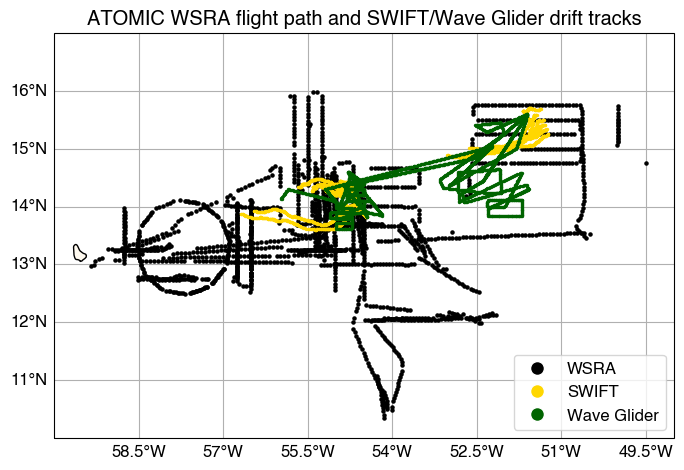

In [77]:
PROJECTION = cartopy.crs.PlateCarree()
IMAGE_RESOLUTION = 400

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=PROJECTION)

atomic_wsra.wsra.chart.ocean_color = 'white'
atomic_wsra.wsra.chart.land_color = 'floralwhite'

atomic_wsra.wsra.plot(
    plot_best_track=False,
    extent=(-60, -49, 10, 17),
    ax=ax,
    label='WSRA'
)

for swift_id, swift_ds in atomic_swifts.items():
    ax.scatter(
        swift_ds['lon'],
        swift_ds['lat'],
        # c=swift_ds['ymd'].values,
        color='gold',
        s=2,
        label='SWIFT'
    )

for wave_glider_id, wave_glider_ds in atomic_wave_gliders.items():
    ax.scatter(
        wave_glider_ds['lon'],
        wave_glider_ds['lat'],
        s=2,
        color='darkgreen',
        label='Wave glider'
    )

legend_elements = [Line2D([0], [0], marker='o', color='w', label='WSRA',
                        markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='SWIFT',
                        markerfacecolor='gold', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Wave Glider',
                        markerfacecolor='darkgreen', markersize=10)]

ax.legend(handles=legend_elements, loc='lower right')
ax.set_title('ATOMIC WSRA flight path and SWIFT/Wave Glider drift tracks')

# fig.savefig(f'ATOMIC_flight_and_drift_tracks.{IMAGE_FILE_TYPE}',
#             format=IMAGE_FILE_TYPE,
#             dpi=IMAGE_RESOLUTION)

## Comparisons by mission

In [93]:
def plot_swift(ax, swift_ds, var, **scatter_kwargs):
    ax.scatter(
        swift_ds['lon'],
        swift_ds['lat'],
        c=swift_ds[var],
        **scatter_kwargs
)

def plot_wsra(ax, cax, wsra_ds, var, **plot_kwargs):
    wsra_ds.wsra.plot(
        ax=ax,
        cax=cax,
        column=var,
        **plot_kwargs
    )


def comparison_plot(ax, cax, wsra_ds, swift_ds, c_array, wsra_var, swift_var, **scatter_kwargs):
    #TODO: color by prox using c?
    sc = ax.scatter(
        swift_ds[swift_var],
        wsra_ds[wsra_var],
        c=c_array,
        **scatter_kwargs
    )
    fig.colorbar(sc, cax=cax, orientation='vertical')


def create_figure():
    fig = plt.figure(figsize=(12, 6))
    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[2, 1], wspace = .35)
    ax1 = fig.add_subplot(gs[0], projection=PROJECTION)
    ax2 = fig.add_subplot(gs[1])

    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", axes_class=mpl.axes.Axes, pad="2%")

    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", axes_class=mpl.axes.Axes, pad="2%")

    return fig, ax1, ax2, cax1, cax2


def create_legend_elements():
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='WSRA', markerfacecolor='k', markersize=10),
        Line2D([0], [0], marker='d', color='w', label='SWIFT', markerfacecolor='k', markersize=10)
    ]
    return legend_elements


### Significant wave height

Create a comparison scatter plot over all mission dates.

Text(0, 0.5, 'SWIFT significant wave height (m)')

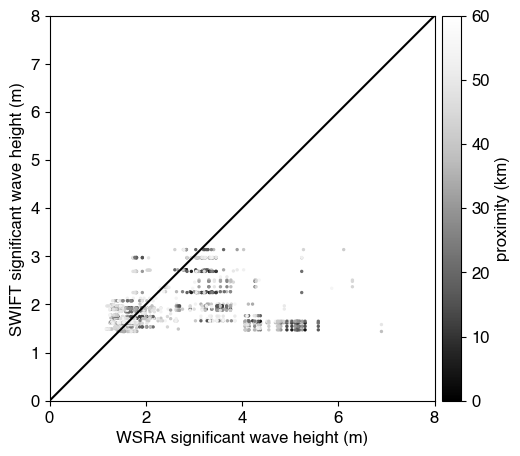

In [105]:
IMAGE_RESOLUTION = 400
limits = [0, 8]
cmap=mpl.cm.Greys_r  # Oranges_r
norm=mpl.colors.Normalize(vmin=0, vmax=60)

fig, ax = plt.subplots(figsize=(6, 5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=mpl.axes.Axes, pad="2%")

for swift_id in atomic_swifts.keys():  # ['SWIFT23']:  #atomic_swifts.keys():

    wsra_indices = np.concatenate(matches_df.xs(swift_id, level=1)['wsra_indices'])
    swift_indices = np.concatenate(matches_df.xs(swift_id, level=1)['swift_indices'])
    distance = np.concatenate(matches_df.xs(swift_id, level=1)['distance'])
    wsra_matches = atomic_wsra.isel(time=wsra_indices)
    swift_matches = atomic_swifts[swift_id].isel(time=swift_indices)
    sc = ax.scatter(
        wsra_matches['sea_surface_wave_significant_height'],
        swift_matches['sea_surface_wave_significant_height'],
        c=distance,
        cmap=cmap,
        norm=norm,
        s=2,
    )
    fig.colorbar(sc, cax=cax, orientation='vertical')

cax.set_ylabel('proximity (km)')
ax.set_aspect('equal')
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.plot(limits, limits, color='k')
ax.set_xlabel('WSRA significant wave height (m)')
ax.set_ylabel('SWIFT significant wave height (m)')
# fig.savefig(f'WSRA_and_SWIFT_mean_square_slope.{IMAGE_FILE_TYPE}',
#             format=IMAGE_FILE_TYPE,
#             dpi=IMAGE_RESOLUTION)

Plot a map and comparison plot per mission (day).

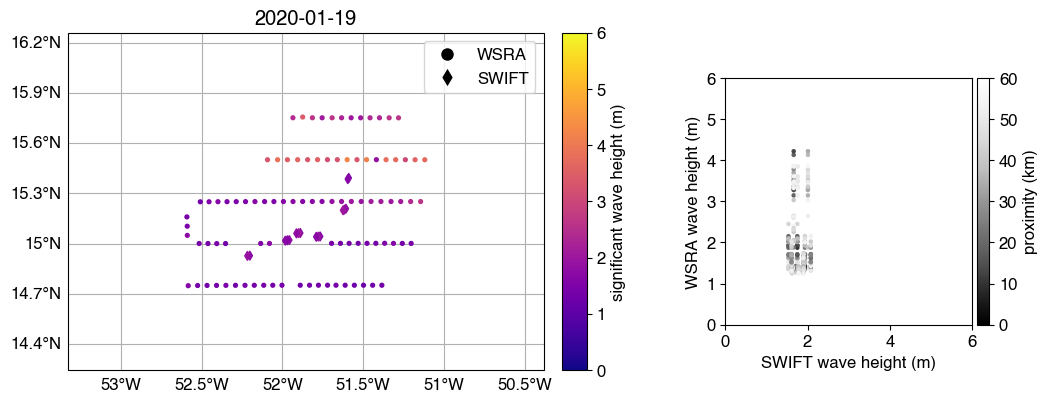

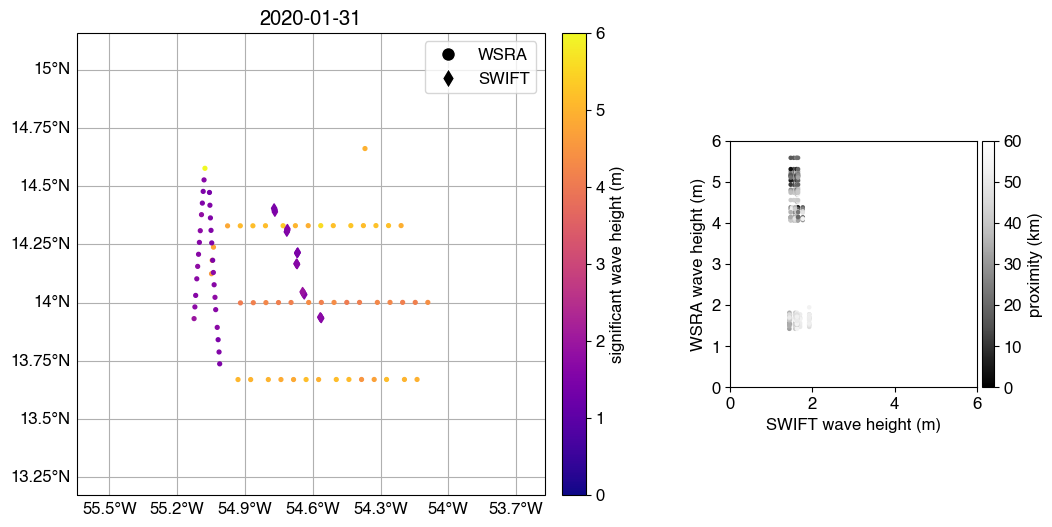

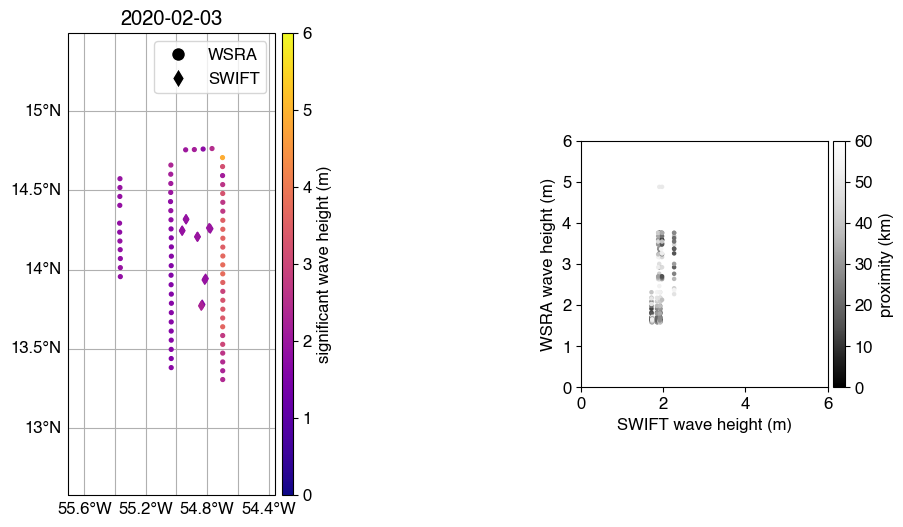

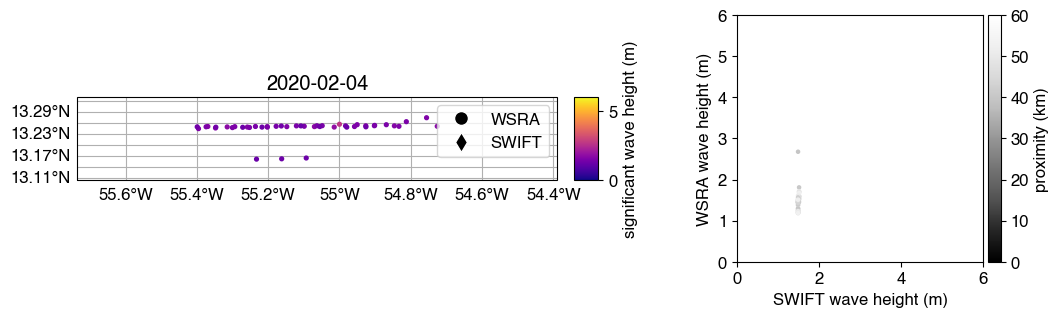

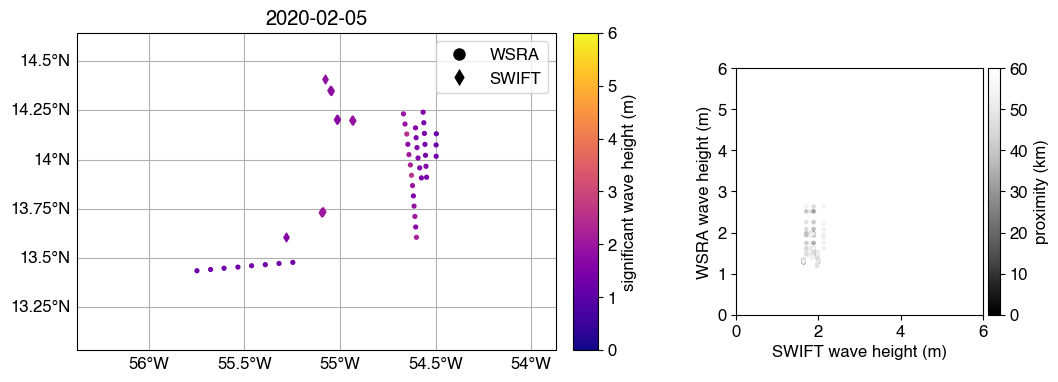

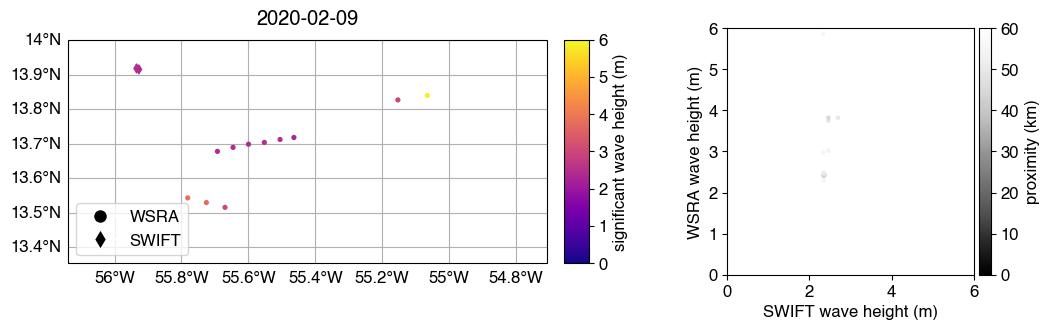

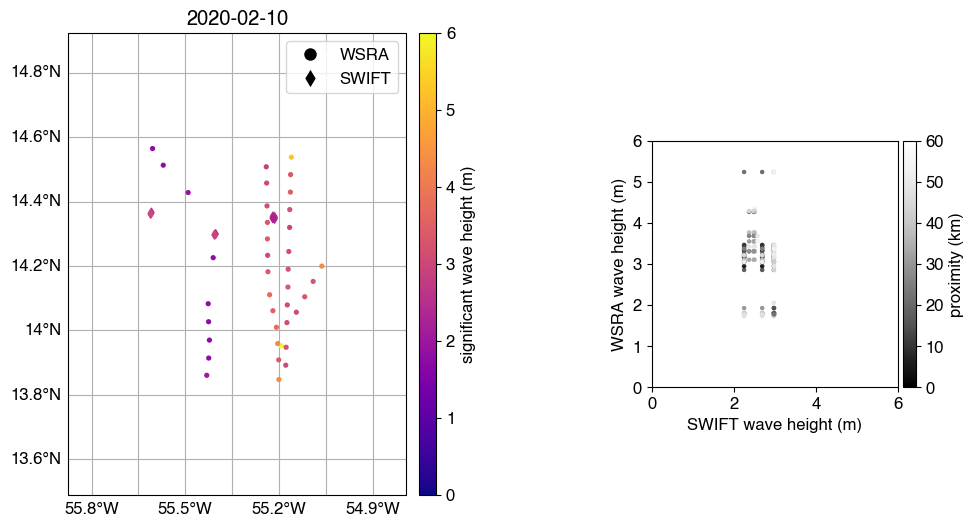

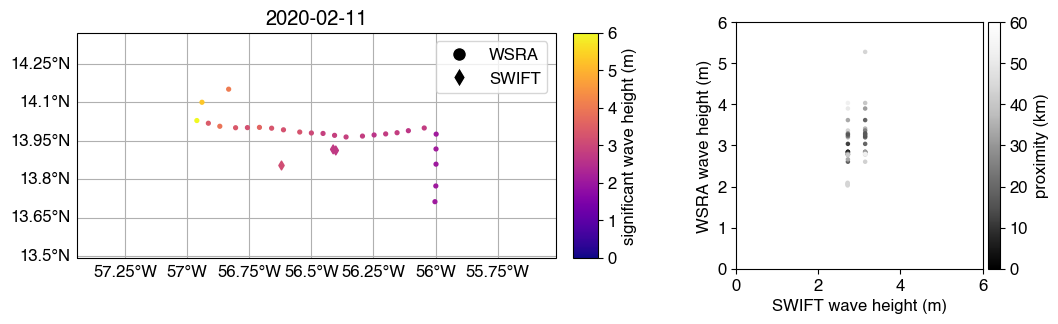

In [103]:
wsra_var='sea_surface_wave_significant_height'
swift_var='sea_surface_wave_significant_height'
cmap_1=mpl.cm.plasma
norm_1=mpl.colors.Normalize(vmin=0, vmax=6)
cmap_2=mpl.cm.Greys_r  # Oranges_r
norm_2=mpl.colors.Normalize(vmin=0, vmax=60)

PROJECTION = cartopy.crs.PlateCarree()
IMAGE_RESOLUTION = 300
SWIFT_SCATTER_KWARGS = dict(
    s=20,
    marker='d',
    label='SWIFT',
    cmap=cmap_1,
    norm=norm_1,
)
WSRA_PLOT_KWARGS = dict(
    legend=True,
    marker='.',
    markersize=30,
    label='WSRA',
    plot_best_track=False,
    cmap=cmap_1,
    norm=norm_1,
    legend_kwds={
        "orientation": "vertical",
        "location": "right",
    }
)
COMPARISON_SCATTER_KWARGS = dict(
    s=5,
    cmap=cmap_2,
    norm=norm_2,
)

mission_dates = np.unique(atomic_wsra['day'].dropna(dim='time'))

for date in mission_dates:

    unique_wsra_indices = np.unique(np.concatenate(matches_df.loc[date]['wsra_indices'].to_numpy()))

    if unique_wsra_indices.size > 0:

        fig, ax_1, ax_2, cax_1, cax_2 = create_figure()

        wsra_in_mission = atomic_wsra.where(atomic_wsra['day'] == date) #, drop=True)
        wsra_matches_unique = wsra_in_mission.isel(time=unique_wsra_indices)
        wsra_matches_unique.wsra.chart.ocean_color = 'white' # 'whitesmoke'
        wsra_matches_unique.wsra.chart.land_color = 'floralwhite'  # white, whitesmoke
        wsra_matches_unique.wsra.chart.buffer_percent=0.5
        plot_wsra(ax_1, cax_1, wsra_matches_unique, wsra_var, **WSRA_PLOT_KWARGS)

        for swift_id in atomic_swifts.keys():
            swift_in_mission = atomic_swifts[swift_id].where(atomic_swifts[swift_id]['day'] == date)

            wsra_indices = matches_df.loc[date].loc[swift_id]['wsra_indices']
            swift_indices = matches_df.loc[date].loc[swift_id]['swift_indices']
            wsra_matches = wsra_in_mission.isel(time=wsra_indices)
            swift_matches = swift_in_mission.isel(time=swift_indices)
            swift_matches_unique = swift_in_mission.isel(time=np.unique(swift_indices))
            plot_swift(ax_1, swift_matches_unique, swift_var, **SWIFT_SCATTER_KWARGS)
            comparison_plot(ax_2, cax_2, wsra_matches, swift_matches,
                            matches_df.loc[date].loc[swift_id]['distance'],
                            wsra_var, swift_var,  **COMPARISON_SCATTER_KWARGS)

        ax_1.set_title(pd.Timestamp(date).strftime('%Y-%m-%d'))
        ax_1.legend(handles=create_legend_elements())

        cax_1.set_ylabel('significant wave height (m)')
        cax_2.set_ylabel('proximity (km)')

        ax_2.set_ylabel('WSRA wave height (m)')
        ax_2.set_xlabel('SWIFT wave height (m)')
        ax_2.set_aspect('equal')
        ax_2.set_ylim([0, 6])
        ax_2.set_xlim([0, 6])
  


### mean square slope

Create a comparison scatter plot over all mission dates.

Text(0.5, 0, 'SWIFT mean square slope')

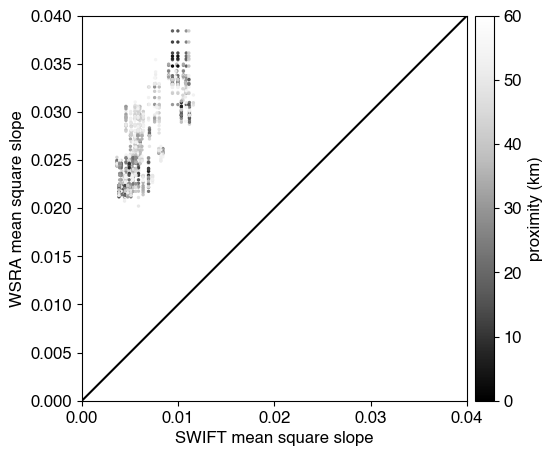

In [92]:
#TODO: color by prox
IMAGE_RESOLUTION = 400
limits = [0, 0.04]
cmap=mpl.cm.Greys_r  # Oranges_r
norm=mpl.colors.Normalize(vmin=0, vmax=60)


fig, ax = plt.subplots(figsize=(6, 5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=mpl.axes.Axes, pad="2%")


for swift_id in atomic_swifts.keys():  # ['SWIFT23']:  #atomic_swifts.keys():

    wsra_indices = np.concatenate(matches_df.xs(swift_id, level=1)['wsra_indices'])
    swift_indices = np.concatenate(matches_df.xs(swift_id, level=1)['swift_indices'])
    distance = np.concatenate(matches_df.xs(swift_id, level=1)['distance'])
    wsra_matches = atomic_wsra.isel(time=wsra_indices)
    swift_matches = atomic_swifts[swift_id].isel(time=swift_indices)
    sc = ax.scatter(
        swift_matches['mean_square_slope'],
        wsra_matches['sea_surface_mean_square_slope_median'],
        c=distance,
        cmap=cmap,
        norm=norm,
        s=2,
    )
    fig.colorbar(sc, cax=cax, orientation='vertical')

cax.set_ylabel('proximity (km)')
ax.set_aspect('equal')
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.plot(limits, limits, color='k')
ax.set_ylabel('WSRA mean square slope')
ax.set_xlabel('SWIFT mean square slope')

# fig.savefig(f'WSRA_and_SWIFT_mean_square_slope.{IMAGE_FILE_TYPE}',
#             format=IMAGE_FILE_TYPE,
#             dpi=IMAGE_RESOLUTION)

Plot a map and comparison plot per mission (day).

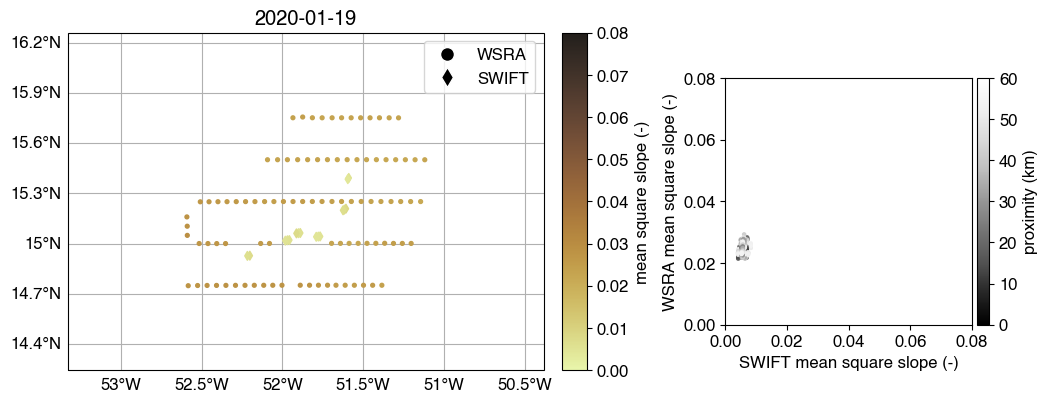

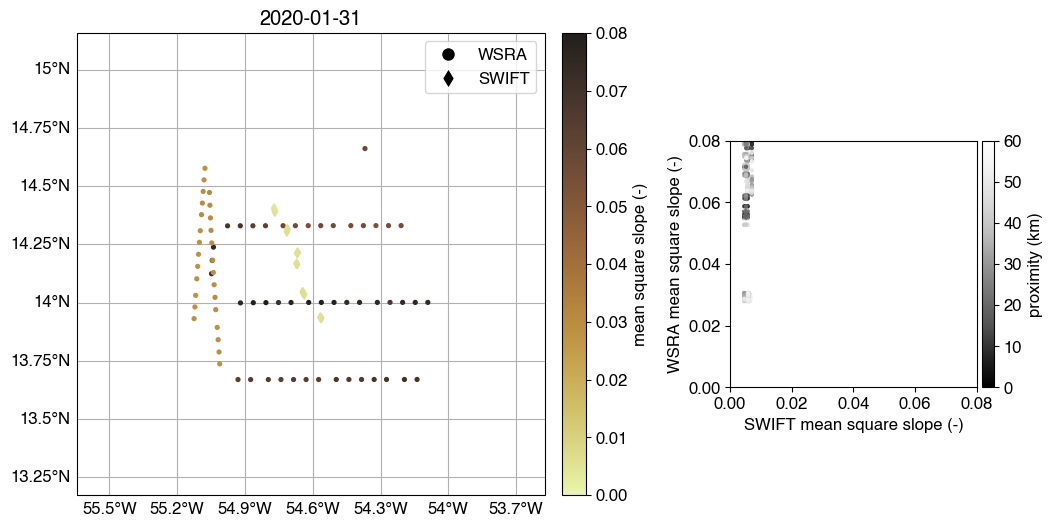

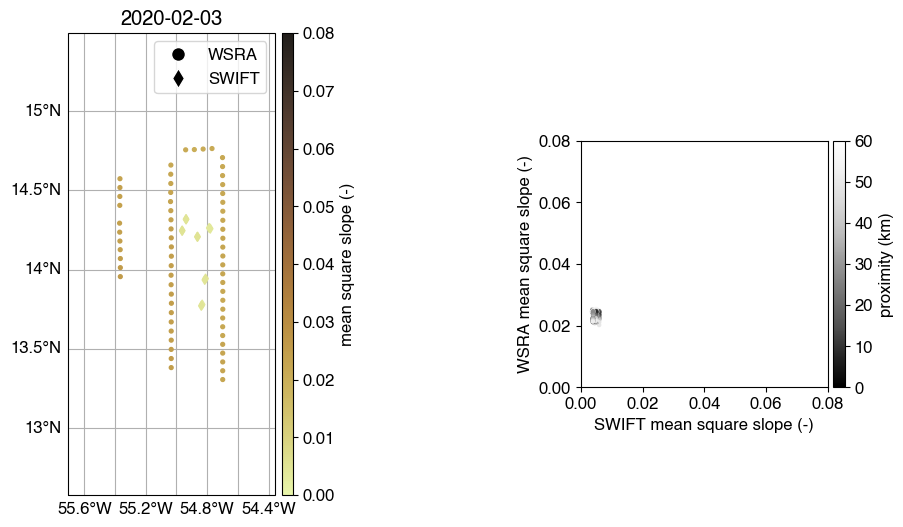

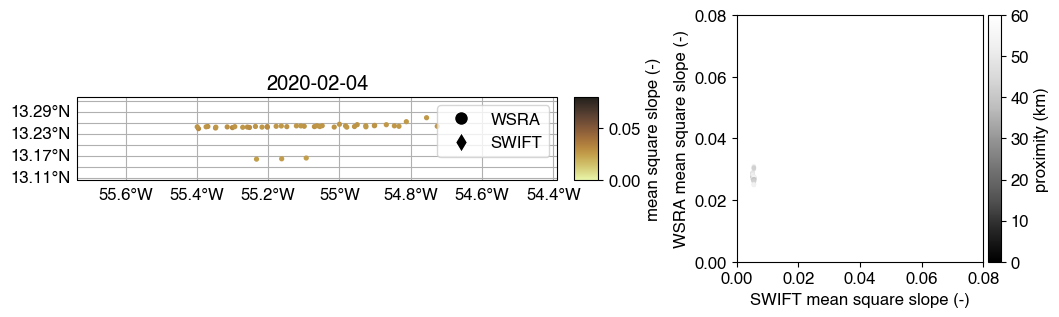

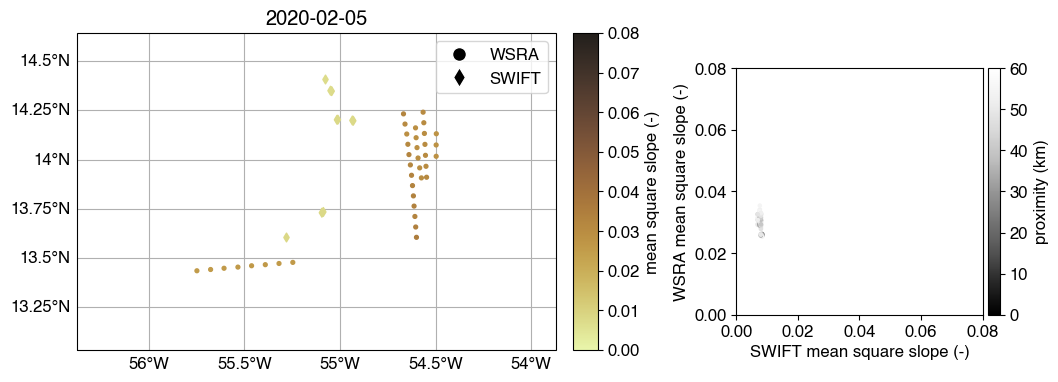

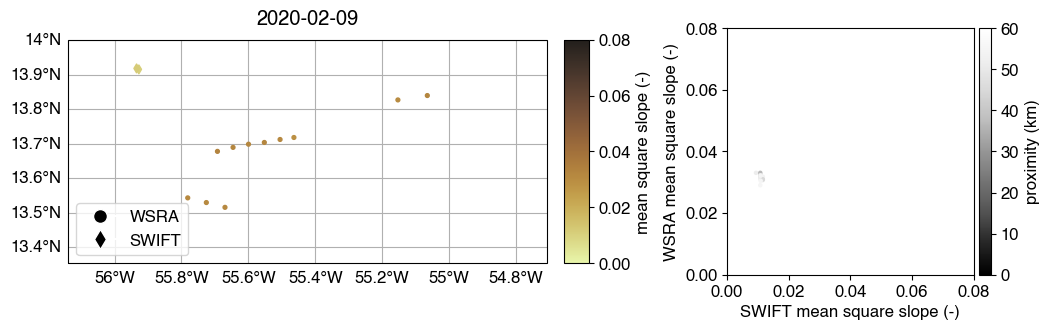

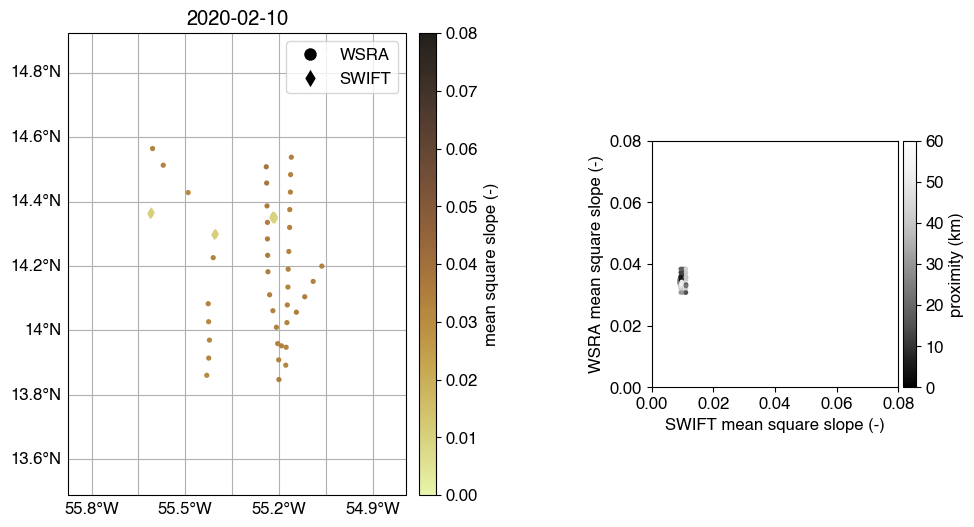

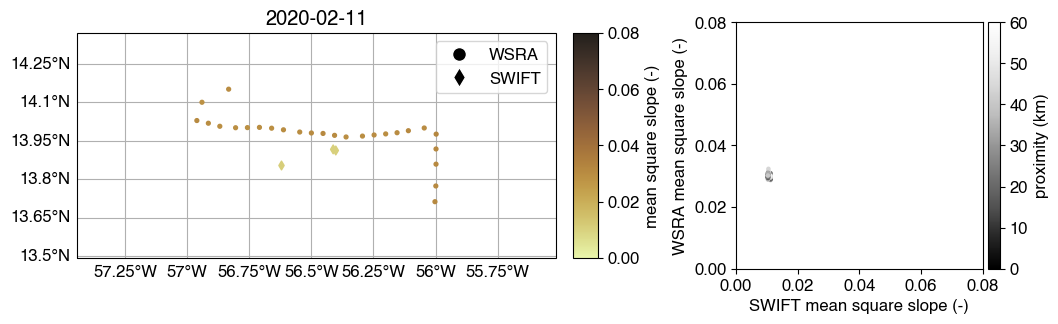

In [104]:
wsra_var='sea_surface_mean_square_slope_median'
swift_var='mean_square_slope'
cmap_1=cmocean.cm.turbid
norm_1=mpl.colors.Normalize(vmin=0, vmax=0.08)
cmap_2=mpl.cm.Greys_r  # Oranges_r
norm_2=mpl.colors.Normalize(vmin=0, vmax=60)

PROJECTION = cartopy.crs.PlateCarree()
IMAGE_RESOLUTION = 300
SWIFT_SCATTER_KWARGS = dict(
    s=20,
    marker='d',
    label='SWIFT',
    cmap=cmap_1,
    norm=norm_1,
)
WSRA_PLOT_KWARGS = dict(
    legend=True,
    marker='.',
    markersize=30,
    label='WSRA',
    plot_best_track=False,
    cmap=cmap_1,
    norm=norm_1,
    legend_kwds={
        "orientation": "vertical",
        "location": "right",
    }
)
COMPARISON_SCATTER_KWARGS = dict(
    s=5,
    cmap=cmap_2,
    norm=norm_2,
)

mission_dates = np.unique(atomic_wsra['day'].dropna(dim='time'))

for date in mission_dates:

    unique_wsra_indices = np.unique(np.concatenate(matches_df.loc[date]['wsra_indices'].to_numpy()))

    if unique_wsra_indices.size > 0:

        fig, ax_1, ax_2, cax_1, cax_2 = create_figure()

        wsra_in_mission = atomic_wsra.where(atomic_wsra['day'] == date)  #, drop=True)
        wsra_matches_unique = wsra_in_mission.isel(time=unique_wsra_indices)
        wsra_matches_unique.wsra.chart.ocean_color = 'white' # 'whitesmoke'
        wsra_matches_unique.wsra.chart.land_color = 'floralwhite'  # white, whitesmoke
        wsra_matches_unique.wsra.chart.buffer_percent=0.5
        plot_wsra(ax_1, cax_1, wsra_matches_unique, wsra_var, **WSRA_PLOT_KWARGS)

        for swift_id in atomic_swifts.keys():
            swift_in_mission = atomic_swifts[swift_id].where(atomic_swifts[swift_id]['day'] == date)

            wsra_indices = matches_df.loc[date].loc[swift_id]['wsra_indices']
            swift_indices = matches_df.loc[date].loc[swift_id]['swift_indices']
            wsra_matches = wsra_in_mission.isel(time=wsra_indices)
            swift_matches = swift_in_mission.isel(time=swift_indices)
            swift_matches_unique = swift_in_mission.isel(time=np.unique(swift_indices))
            plot_swift(ax_1, swift_matches_unique, swift_var, **SWIFT_SCATTER_KWARGS)
            comparison_plot(ax_2, cax_2, wsra_matches, swift_matches,
                            matches_df.loc[date].loc[swift_id]['distance'],
                            wsra_var, swift_var,  **COMPARISON_SCATTER_KWARGS)

        ax_1.set_title(pd.Timestamp(date).strftime('%Y-%m-%d'))
        ax_1.legend(handles=create_legend_elements())

        cax_1.set_ylabel('mean square slope (-)')
        cax_2.set_ylabel('proximity (km)')

        ax_2.set_ylabel('WSRA mean square slope (-)')
        ax_2.set_xlabel('SWIFT mean square slope (-)')
        ax_2.set_aspect('equal')
        ax_2.set_ylim([0, 0.08])
        ax_2.set_xlim([0, 0.08])

